<a href="https://colab.research.google.com/github/revak18/nicotine_use_mathmodel/blob/main/NicotineUse_SIR_DDE_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ddeint

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint

# Constants
B = 0.00103  # Birth rate per month
mu = 0.0006254  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12) # 7 years to transition from 'youth' (11yrs) to 'young adult' (18yrs)
aging_rate_ya_to_a = 1 / (5 * 12)  # 5 years to transition from 'young adult' (18yrs)  to 'adult' (23yrs)


# tau_1: Delay for Infection (12 months)
tau_1 = 12
# Justification: The delay for infection (tau_1 = 12 months) reflects the time it might take for susceptible individuals
# to initiate Nicotine use. This delay can account for the gradual exposure to influencing factors like peer pressure,
# marketing, and social trends, which do not immediately result in uptake but may do so over an extended period.
# A year-long delay allows for these influences to accumulate and reflect realistic patterns seen in epidemiological studies
# of behavior adoption where repeated exposures increase the likelihood of adoption.

# tau_2:  Delay for Recovery (6 months)
tau_2 = 6
# How Long Does it Take to Break a Nicotine Addiction?
# https://www.urbanrecovery.com/blog/how-long-does-it-take-to-break-a-nicotine-addiction
# The recovery delay (tau_2 = 6 months) represents the time it might take for an individual to cease using nicotine products.
# Weeks 1-2	Physical withdrawal: During this period, the body adjusts to the absence of nicotine. Withdrawal symptoms are typically at their peak.

# Weeks 3-4	Psychological adjustments: As the physical withdrawal symptoms subside, individuals may still experience psychological cravings and triggers.
# This period focuses on addressing the psychological aspects of addiction.

# Months 1-6	Consolidating recovery: The cravings become less frequent and intense during this period. Individuals continue to refine coping strategies
# and adjust to life without nicotine.

# Beyond 6 Months	Maintaining a smoke-free life: After six months, many individuals experience a significant reduction in cravings and a sense of freedom
# from nicotine addiction. However, it's important to remain vigilant and continue implementing healthy habits to prevent relapse.


# tau_3: Delay for Relapse (12 months)
tau_3 = 12
# Stages of Change Theory: https://www.ncbi.nlm.nih.gov/books/NBK556005/
# "A longitudinal study from the 1990 Surgeon General's Report showed that after 12 months of abstinence, 43% of people returned to their smoking habit."

In [19]:
import numpy as np
import random

#########################################
# beta: Infection coefficient
#########################################
# "If one of your best friends offered you a cigarette, would you smoke it?"
#  For e-cigarettes, 18% responded "yes" - 2016 U.S. Surgeon General report
#  For cigarettes, 0.3% responded "yes" - 2014 National Survey on Drug Use and Health
#  Calculates beta using "18%" & flg="EC"(e-cigarettes) OR 3% & flg="C"(cigarettes) as seed and seasonal variation.

def beta(t, flg):
  if flg == 'EC':
     beta = 0.18 + (random.random()/100) * np.cos(t / 12 * np.pi)
  else:
     beta = 0.003 + (random.random()/1000) * np.cos(t / 12 * np.pi)
  return beta


#########################################
# gamma: Recovery coefficients
#########################################
# Smoking Cessation: Fast Facts
# https://www.cdc.gov/tobacco/php/data-statistics/smoking-cessation/index.html
# In 2022, 67.7% of adults who smoked said they wanted to quit smoking.

# Quitting e-cigarettes: Quit attempts and quit intentions among youth and young adults
# https://pmc.ncbi.nlm.nih.gov/articles/PMC7808959/#:~:text=3.2.-,Cessation%20outcomes,reported%20general%20intentions%20to%20quit.
# Among current e-cigarette users, 33.3% reported a past-year quit attempt

# Calculates gamma using "33.30%" & flg="EC"(e-cigarettes) OR 67.70% & flg="C"(cigarettes) as seed and seasonal variation.
def gamma(t, flg):
  if flg == 'EC':
     gamma = (1.333 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
  else:
     gamma = (1.677 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #cigarettes
  return gamma


#########################################
# rho: Relapse coefficients
#########################################
# Smoking Cessation: Fast Facts
# https://www.cdc.gov/tobacco/php/data-statistics/smoking-cessation/index.html
# In 2022, 8.8% of adults who smoked were able to successfully quit smoking in the past year.
# That means 100 - 8.8 = 91.2% relapsed.

# Effectiveness of e-cigarettes as aids for smoking cessation: evidence from the PATH Study cohort, 2017–2019
# https://tobaccocontrol.bmj.com/content/32/e2/e145
# Furthermore, switching to e-cigarettes did not reduce the risk of relapse to cigarette smoking compared with other recent former smokers.
# Instead, nearly 60% of recent former smokers who were daily e-cigarette users had relapsed to cigarette smoking by 2019 (W5).

# Calculates rho using "60.00%" & flg="EC"(e-cigarettes) OR 91.20% & flg="C"(cigarettes) as seed and seasonal variation.
def rho(t, flg):
  if flg == 'EC':
     rho = (1.600 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
  else:
     rho = (1.912 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #cigarettes
  return rho

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ode.py:431: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


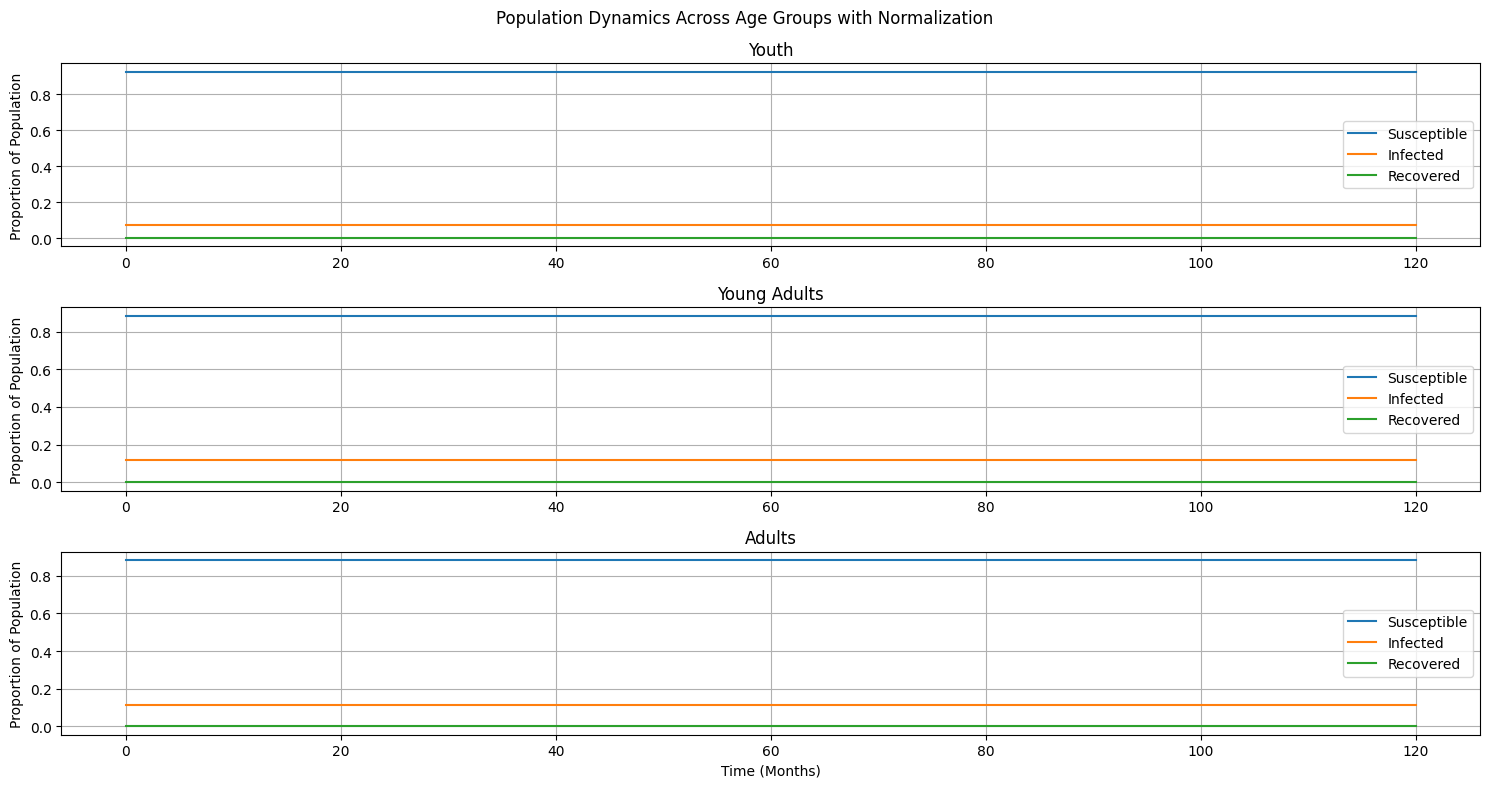

In [34]:
#S_y, I_y, R_y: Proportion of susceptible, infected, and recovered individuals in the Youth age group.
#S_ya, I_ya, R_ya: Proportion of susceptible, infected, and recovered individuals in the Young Adult age group.
#S_a, I_a, R_a: Proportion of susceptible, infected, and recovered individuals in the Adult age group.
#τ₁ (tau_1), τ₂ (tau_2), and τ₃ (tau_3): Delays associated with initiation, cessation, and relapse processes.
#These delays reflect the time lag between exposure to nicotine use and the onset of regular use,
# the time required for successful cessation, and the time it takes for a former user to relapse.

# Model definition
def model(Y, t, flg):
    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
        R_y_delay = Y(t - tau_1)[2]
    else:
        S_y_delay, I_y_delay, R_y_delay = S_y, I_y, R_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
    else:
        I_y_delay2 = I_y

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
    else:
        R_y_delay3 = R_y

    # Population dynamics
    dS_y_dt = B - beta(t, flg) * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta(t, flg) * S_y * I_y_delay - (mu + gamma(t, flg)) * I_y_delay2 + rho(t, flg) * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma(t, flg) * I_y_delay2 - (mu + rho(t, flg)) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta(t, flg) * S_ya * I_ya - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta(t, flg) * S_ya * I_ya - (mu + gamma(t, flg)) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma(t, flg) * I_ya - (mu + rho(t, flg)) * R_ya - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta(t, flg) * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta(t, flg) * S_a * I_a - (mu + gamma(t, flg)) * I_a
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma(t, flg) * I_a - (mu + rho(t, flg)) * R_a

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

# Initial conditions and history function
# Ref: https://www.cdc.gov/tobacco/media/pdfs/2024/09/cdc-osh-ncis-data-report-508.pdf
# Percent of adults age 18 and older who currently smoke: For this model *** "Adults" and "Yound Adults" ***
# E-cigarettes: 6.0% --> Infected, I0 = 0.0600 , Susceptible, S0 = 1 - I0 = 1 - 0.0600 = 0.9400, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.
# cigarettes: 11.6%  --> Infected, I0 = 0.1160 , Susceptible, S0 = 1 - I0 = 1 - 0.1160 = 0.8840, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.

# Ref: https://www.cdc.gov/nchs/fastats/smoking.htm
# Percent of adolescents who currently smoke: For this model "Youth"
# E-cigarettes: 24.7% --> Infected, I0 = 0.2470 , Susceptible, S0 = 1 - I0 = 1 - 0.2470 = 0.7530, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.
# cigarettes: 7.5%    --> Infected, I0 = 0.0750 , Susceptible, S0 = 1 - I0 = 1 - 0.0750 = 0.9250, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.

#E-cigarettes "Adults" and "Yound Adults" : S0, I0, R0 = 0.9400, 0.0600, 0.0000
#E-cigarettes "Youth"                     : S0, I0, R0 = 0.7530, 0.2470, 0.0000
#cigarettes "Adults" and "Yound Adults"   : S0, I0, R0 = 0.8840, 0.1160, 0.0000
#cigarettes "Youth"                       : S0, I0, R0 = 0.9250, 0.0750, 0.0000

def history(t):
    if flg == 'EC':
       return [0.7530, 0.2470, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults
    else:
       return [0.9250, 0.0750, 0.0000, 0.8840, 0.1160, 0.0000, 0.8840, 0.1160, 0.0000]  # Initial values for Cigarettes all states of Youth, Young Adults and Adults

# Time vector
t = np.linspace(0, 120, 120)  # Simulate for 10 years

#Flag
#flg = 'EC' # e-cigarettes
flg = 'C'  # cigarettes

# Solve DDE
sol = ddeint(model, history, t, fargs=(flg,))

# Normalize the solution (after solving DDE)
#total_pop = sol.sum(axis=1)  # Sum across all population groups
#sol = sol / total_pop[:, np.newaxis]  # Normalize each group by total population

# Plotting results
plt.figure(figsize=(15, 8))
# Subplot for Youth
plt.subplot(3, 1, 1)
plt.plot(t, sol[:, 0], label='Susceptible')
plt.plot(t, sol[:, 1], label='Infected')
plt.plot(t, sol[:, 2], label='Recovered')
plt.title('Youth')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Young Adults
plt.subplot(3, 1, 2)
plt.plot(t, sol[:, 3], label='Susceptible')
plt.plot(t, sol[:, 4], label='Infected')
plt.plot(t, sol[:, 5], label='Recovered')
plt.title('Young Adults')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Adults
plt.subplot(3, 1, 3)
plt.plot(t, sol[:, 6], label='Susceptible')
plt.plot(t, sol[:, 7], label='Infected')
plt.plot(t, sol[:, 8], label='Recovered')
plt.title('Adults')
plt.xlabel('Time (Months)')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

plt.suptitle('Population Dynamics Across Age Groups with Normalization')
plt.tight_layout()
plt.show()

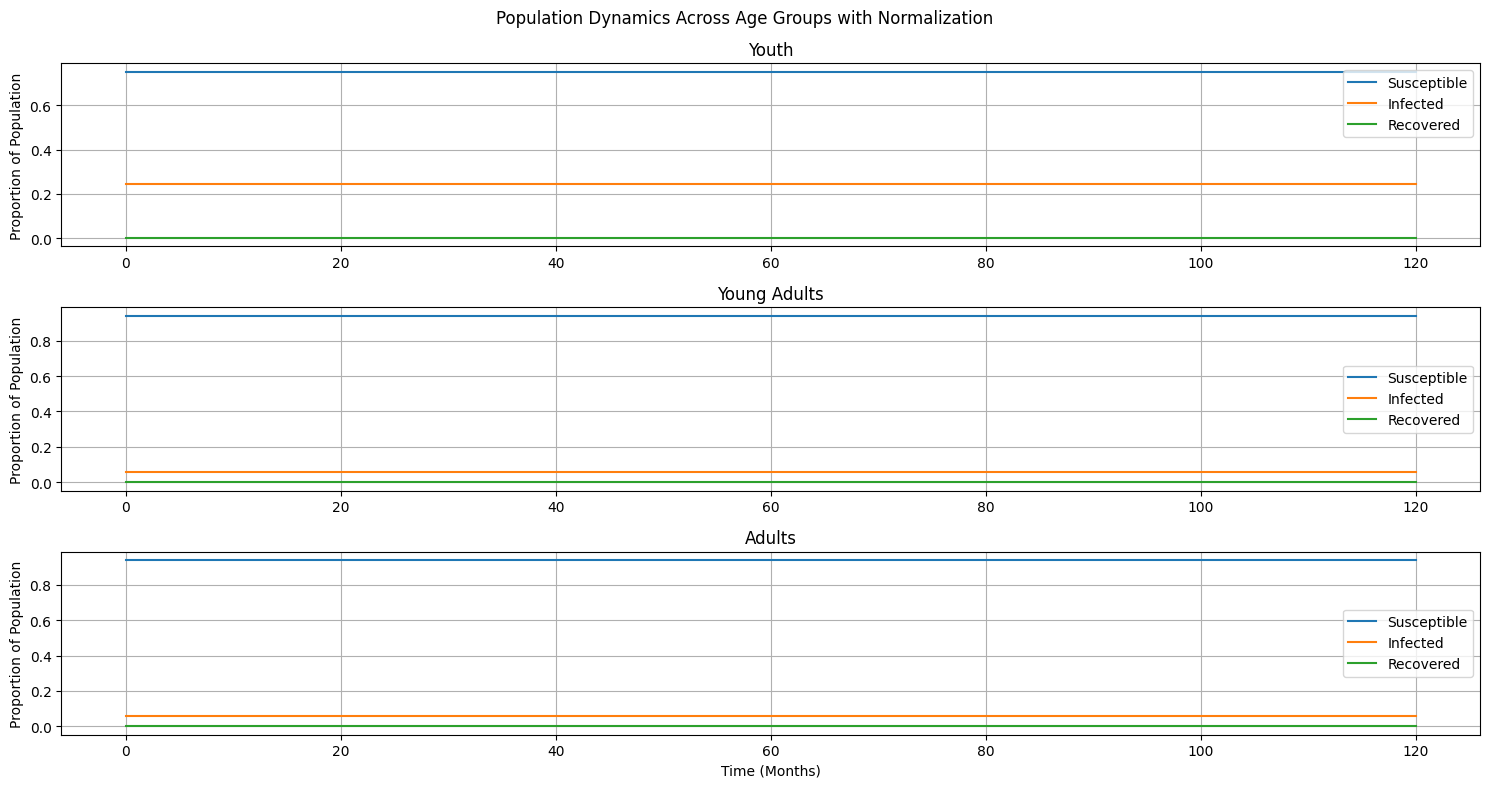

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint

# Constants
B = 0.00103  # Birth rate per month
mu = 0.0006254  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12) # 7 years to transition from 'youth' (11yrs) to 'young adult' (18yrs)
aging_rate_ya_to_a = 1 / (5 * 12)  # 5 years to transition from 'young adult' (18yrs)  to 'adult' (23yrs)


# tau_1: Delay for Infection (12 months)
tau_1 = 12
# Justification: The delay for infection (tau_1 = 12 months) reflects the time it might take for susceptible individuals
# to initiate Nicotine use. This delay can account for the gradual exposure to influencing factors like peer pressure,
# marketing, and social trends, which do not immediately result in uptake but may do so over an extended period.
# A year-long delay allows for these influences to accumulate and reflect realistic patterns seen in epidemiological studies
# of behavior adoption where repeated exposures increase the likelihood of adoption.

# tau_2:  Delay for Recovery (6 months)
tau_2 = 6
# How Long Does it Take to Break a Nicotine Addiction?
# https://www.urbanrecovery.com/blog/how-long-does-it-take-to-break-a-nicotine-addiction
# The recovery delay (tau_2 = 6 months) represents the time it might take for an individual to cease using nicotine products.
# Weeks 1-2	Physical withdrawal: During this period, the body adjusts to the absence of nicotine. Withdrawal symptoms are typically at their peak.

# Weeks 3-4	Psychological adjustments: As the physical withdrawal symptoms subside, individuals may still experience psychological cravings and triggers.
# This period focuses on addressing the psychological aspects of addiction.

# Months 1-6	Consolidating recovery: The cravings become less frequent and intense during this period. Individuals continue to refine coping strategies
# and adjust to life without nicotine.

# Beyond 6 Months	Maintaining a smoke-free life: After six months, many individuals experience a significant reduction in cravings and a sense of freedom
# from nicotine addiction. However, it's important to remain vigilant and continue implementing healthy habits to prevent relapse.


# tau_3: Delay for Relapse (12 months)
tau_3 = 12
# Stages of Change Theory: https://www.ncbi.nlm.nih.gov/books/NBK556005/
# "A longitudinal study from the 1990 Surgeon General's Report showed that after 12 months of abstinence, 43% of people returned to their smoking habit."

import numpy as np
import random

#########################################
# beta: Infection coefficient
#########################################
# "If one of your best friends offered you a cigarette, would you smoke it?"
#  For e-cigarettes, 18% responded "yes" - 2016 U.S. Surgeon General report
#  For cigarettes, 0.3% responded "yes" - 2014 National Survey on Drug Use and Health
#  Calculates beta using "18%" & flg="EC"(e-cigarettes) OR 3% & flg="C"(cigarettes) as seed and seasonal variation.

def beta(t):
    beta = 0.18 + (random.random()/100) * np.cos(t / 12 * np.pi)  # e-cigarettes
    #beta = 0.003 + (random.random()/1000) * np.cos(t / 12 * np.pi) # cigarettes
    return beta


#########################################
# gamma: Recovery coefficients
#########################################
# Smoking Cessation: Fast Facts
# https://www.cdc.gov/tobacco/php/data-statistics/smoking-cessation/index.html
# In 2022, 67.7% of adults who smoked said they wanted to quit smoking.

# Quitting e-cigarettes: Quit attempts and quit intentions among youth and young adults
# https://pmc.ncbi.nlm.nih.gov/articles/PMC7808959/#:~:text=3.2.-,Cessation%20outcomes,reported%20general%20intentions%20to%20quit.
# Among current e-cigarette users, 33.3% reported a past-year quit attempt

# Calculates gamma using "33.30%" & flg="EC"(e-cigarettes) OR 67.70% & flg="C"(cigarettes) as seed and seasonal variation.
def gamma(t):
    gamma = (1.333 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
    #gamma = (1.677 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #cigarettes
    return gamma


#########################################
# rho: Relapse coefficients
#########################################
# Smoking Cessation: Fast Facts
# https://www.cdc.gov/tobacco/php/data-statistics/smoking-cessation/index.html
# In 2022, 8.8% of adults who smoked were able to successfully quit smoking in the past year.
# That means 100 - 8.8 = 91.2% relapsed.

# Effectiveness of e-cigarettes as aids for smoking cessation: evidence from the PATH Study cohort, 2017–2019
# https://tobaccocontrol.bmj.com/content/32/e2/e145
# Furthermore, switching to e-cigarettes did not reduce the risk of relapse to cigarette smoking compared with other recent former smokers.
# Instead, nearly 60% of recent former smokers who were daily e-cigarette users had relapsed to cigarette smoking by 2019 (W5).

# Calculates rho using "60.00%" & flg="EC"(e-cigarettes) OR 91.20% & flg="C"(cigarettes) as seed and seasonal variation.
def rho(t):
    rho = (1.600 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
    #rho = (1.912 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #cigarettes
    return rho


#S_y, I_y, R_y: Proportion of susceptible, infected, and recovered individuals in the Youth age group.
#S_ya, I_ya, R_ya: Proportion of susceptible, infected, and recovered individuals in the Young Adult age group.
#S_a, I_a, R_a: Proportion of susceptible, infected, and recovered individuals in the Adult age group.
#τ₁ (tau_1), τ₂ (tau_2), and τ₃ (tau_3): Delays associated with initiation, cessation, and relapse processes.
#These delays reflect the time lag between exposure to nicotine use and the onset of regular use,
# the time required for successful cessation, and the time it takes for a former user to relapse.

# Model definition
def model(Y, t):
    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
        R_y_delay = Y(t - tau_1)[2]
    else:
        S_y_delay, I_y_delay, R_y_delay = S_y, I_y, R_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
    else:
        I_y_delay2 = I_y

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
    else:
        R_y_delay3 = R_y

    # Population dynamics
    dS_y_dt = B - beta(t) * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta(t) * S_y * I_y_delay - (mu + gamma(t)) * I_y_delay2 + rho(t) * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma(t) * I_y_delay2 - (mu + rho(t)) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta(t) * S_ya * I_ya - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta(t) * S_ya * I_ya - (mu + gamma(t)) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma(t) * I_ya - (mu + rho(t)) * R_ya - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta(t) * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta(t) * S_a * I_a - (mu + gamma(t)) * I_a
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma(t) * I_a - (mu + rho(t)) * R_a

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

# Initial conditions and history function
# Ref: https://www.cdc.gov/tobacco/media/pdfs/2024/09/cdc-osh-ncis-data-report-508.pdf
# Percent of adults age 18 and older who currently smoke: For this model *** "Adults" and "Yound Adults" ***
# E-cigarettes: 6.0% --> Infected, I0 = 0.0600 , Susceptible, S0 = 1 - I0 = 1 - 0.0600 = 0.9400, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.
# cigarettes: 11.6%  --> Infected, I0 = 0.1160 , Susceptible, S0 = 1 - I0 = 1 - 0.1160 = 0.8840, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.

# Ref: https://www.cdc.gov/nchs/fastats/smoking.htm
# Percent of adolescents who currently smoke: For this model "Youth"
# E-cigarettes: 24.7% --> Infected, I0 = 0.2470 , Susceptible, S0 = 1 - I0 = 1 - 0.2470 = 0.7530, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.
# cigarettes: 7.5%    --> Infected, I0 = 0.0750 , Susceptible, S0 = 1 - I0 = 1 - 0.0750 = 0.9250, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.

#E-cigarettes "Adults" and "Yound Adults" : S0, I0, R0 = 0.9400, 0.0600, 0.0000
#E-cigarettes "Youth"                     : S0, I0, R0 = 0.7530, 0.2470, 0.0000
#cigarettes "Adults" and "Yound Adults"   : S0, I0, R0 = 0.8840, 0.1160, 0.0000
#cigarettes "Youth"                       : S0, I0, R0 = 0.9250, 0.0750, 0.0000

def history(t):
    return [0.7530, 0.2470, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults
    #return [0.9250, 0.0750, 0.0000, 0.8840, 0.1160, 0.0000, 0.8840, 0.1160, 0.0000]  # Initial values for Cigarettes all states of Youth, Young Adults and Adults

# Time vector
t = np.linspace(0, 120, 120)  # Simulate for 10 years

# Solve DDE
sol = ddeint(model, history, t)

# Normalize the solution (after solving DDE)
#total_pop = sol.sum(axis=1)  # Sum across all population groups
#sol = sol / total_pop[:, np.newaxis]  # Normalize each group by total population

# Plotting results
plt.figure(figsize=(15, 8))
# Subplot for Youth
plt.subplot(3, 1, 1)
plt.plot(t, sol[:, 0], label='Susceptible')
plt.plot(t, sol[:, 1], label='Infected')
plt.plot(t, sol[:, 2], label='Recovered')
plt.title('Youth')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Young Adults
plt.subplot(3, 1, 2)
plt.plot(t, sol[:, 3], label='Susceptible')
plt.plot(t, sol[:, 4], label='Infected')
plt.plot(t, sol[:, 5], label='Recovered')
plt.title('Young Adults')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Adults
plt.subplot(3, 1, 3)
plt.plot(t, sol[:, 6], label='Susceptible')
plt.plot(t, sol[:, 7], label='Infected')
plt.plot(t, sol[:, 8], label='Recovered')
plt.title('Adults')
plt.xlabel('Time (Months)')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

plt.suptitle('Population Dynamics Across Age Groups with Normalization')
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint
import random

B = 0.00103  # Birth rate per month
mu = 0.0006254  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12) # 7 years to transition from 'youth' (11yrs) to 'young adult' (18yrs)
aging_rate_ya_to_a = 1 / (5 * 12)  # 5 years to transition from 'young adult' (18yrs)  to 'adult' (23yrs)
tau_1 = 12
tau_2 = 6
tau_3 = 12

t = np.linspace(0, 120, 120)  # Simulate for 10 years

def beta(t):
    beta = 0.18 + (random.random()/100) * np.cos(t / 12 * np.pi)  # e-cigarettes
    return beta

def gamma(t):
    gamma = (1.333 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
    return gamma

def rho(t):
    rho = (1.600 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
    return rho

def model(Y, t):
    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
        R_y_delay = Y(t - tau_1)[2]
    else:
        S_y_delay, I_y_delay, R_y_delay = S_y, I_y, R_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
    else:
        I_y_delay2 = I_y

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
    else:
        R_y_delay3 = R_y

    # Population dynamics
    dS_y_dt = B - beta(t) * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta(t) * S_y * I_y_delay - (mu + gamma(t)) * I_y_delay2 + rho(t) * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma(t) * I_y_delay2 - (mu + rho(t)) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta(t) * S_ya * I_ya - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta(t) * S_ya * I_ya - (mu + gamma(t)) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma(t) * I_ya - (mu + rho(t)) * R_ya - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta(t) * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta(t) * S_a * I_a - (mu + gamma(t)) * I_a
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma(t) * I_a - (mu + rho(t)) * R_a

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

def history(t):
    return [0.7530, 0.2470, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults

t = np.linspace(0, 120, 120)  # Simulate for 10 years

# Solve DDE
sol = ddeint(model, history, t)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ode.py:431: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


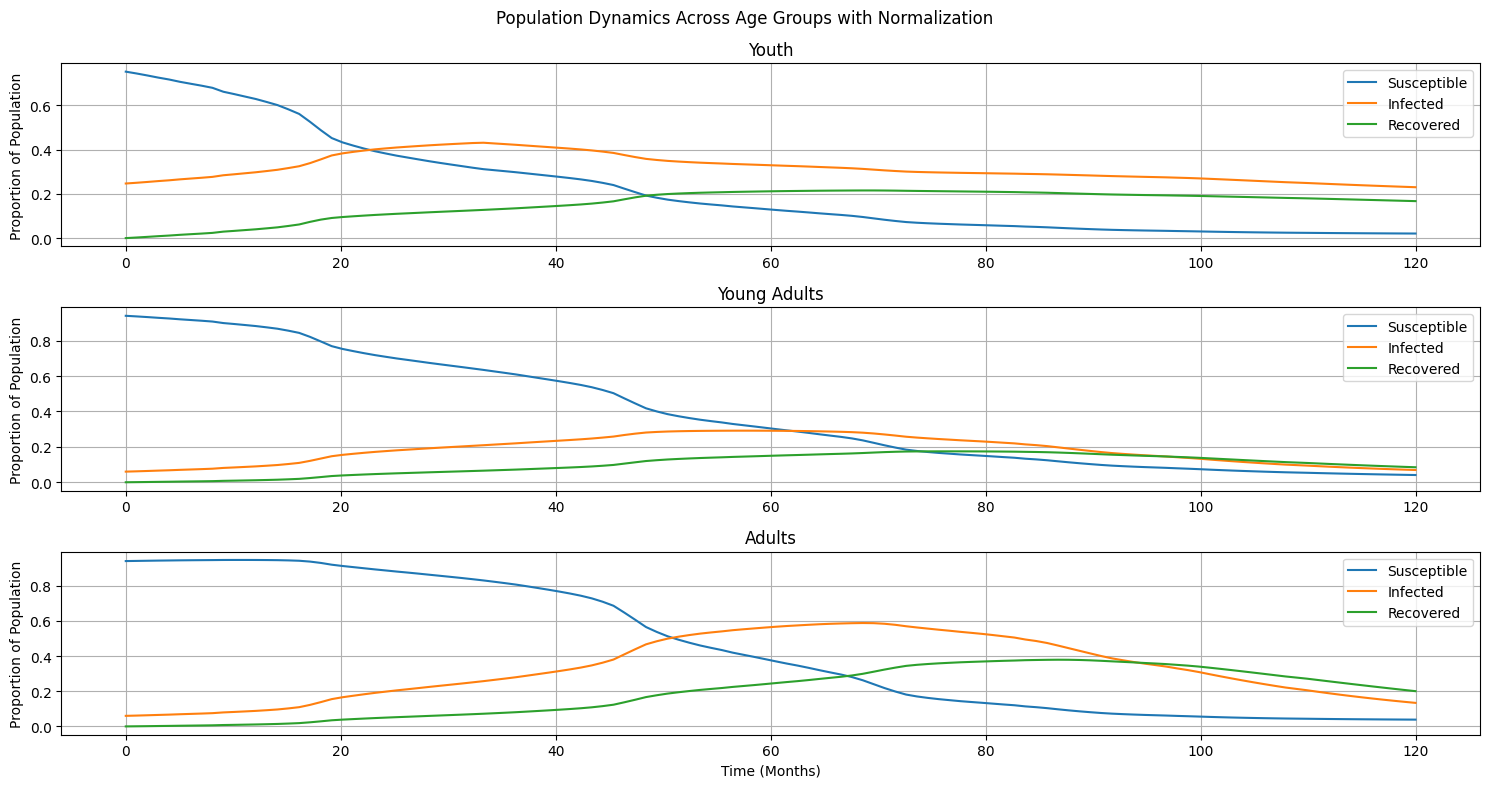

In [7]:
# Plotting results
plt.figure(figsize=(15, 8))
# Subplot for Youth
plt.subplot(3, 1, 1)
plt.plot(t, sol[:, 0], label='Susceptible')
plt.plot(t, sol[:, 1], label='Infected')
plt.plot(t, sol[:, 2], label='Recovered')
plt.title('Youth')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Young Adults
plt.subplot(3, 1, 2)
plt.plot(t, sol[:, 3], label='Susceptible')
plt.plot(t, sol[:, 4], label='Infected')
plt.plot(t, sol[:, 5], label='Recovered')
plt.title('Young Adults')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Adults
plt.subplot(3, 1, 3)
plt.plot(t, sol[:, 6], label='Susceptible')
plt.plot(t, sol[:, 7], label='Infected')
plt.plot(t, sol[:, 8], label='Recovered')
plt.title('Adults')
plt.xlabel('Time (Months)')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

plt.suptitle('Population Dynamics Across Age Groups with Normalization')
plt.tight_layout()
plt.show()

In [21]:
!pip install ddeint

In [76]:
import numpy as np
import random

def linspace_integers(start, stop, num):
  step = (stop - start) // (num - 1)  # Use integer division (floor division)
  return np.arange(start, stop + step, step, dtype=int)

# Example usage:
t = linspace_integers(0, 419, 420)

def beta_values(t):
    beta_value = 0.18 + (random.random()/100) * np.cos(t / 12 * np.pi)  # e-cigarettes
    return beta_value

def gamma_values(t):
    gamma_value = (1.333 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
    return gamma_value

def rho_values(t):
    rho_value = (1.600 **(1/12) - 1) + (random.random()/100) * np.cos(t / 12 * np.pi) #e-cigarettes
    return rho_value

beta = np.array([beta_values(t_i) for t_i in t])
gamma = np.array([gamma_values(t_i) for t_i in t])
rho = np.array([rho_values(t_i) for t_i in t])


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint
import random

B = 0.00103  # Birth rate per month
mu = 0.0006254  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12) # 7 years to transition from 'youth' (11yrs) to 'young adult' (18yrs)
aging_rate_ya_to_a = 1 / (5 * 12)  # 5 years to transition from 'young adult' (18yrs)  to 'adult' (23yrs)
tau_1 = 12
tau_2 = 6
tau_3 = 12

def model(Y, t):

    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
        R_y_delay = Y(t - tau_1)[2]
    else:
        S_y_delay, I_y_delay, R_y_delay = S_y, I_y, R_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
    else:
        I_y_delay2 = I_y

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
    else:
        R_y_delay3 = R_y

    t = int(t)

    # Population dynamics
    dS_y_dt = B - beta[t] * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta[t] * S_y * I_y_delay - (mu + gamma[t]) * I_y_delay2 + rho[t] * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma[t] * I_y_delay2 - (mu + rho[t]) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta[t] * S_ya * I_ya - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta[t]* S_ya * I_ya - (mu + gamma[t]) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma[t] * I_ya - (mu + rho[t]) * R_ya - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta[t] * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta[t] * S_a * I_a - (mu + gamma[t]) * I_a
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma[t] * I_a - (mu + rho[t]) * R_a

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

def history(t):
    return [0.7530, 0.2470, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults

# Solve DDE
t = np.linspace(0, 120, 120)  # Simulate for 10 years
t = t.astype('int32')
sol = ddeint(model, history, t)

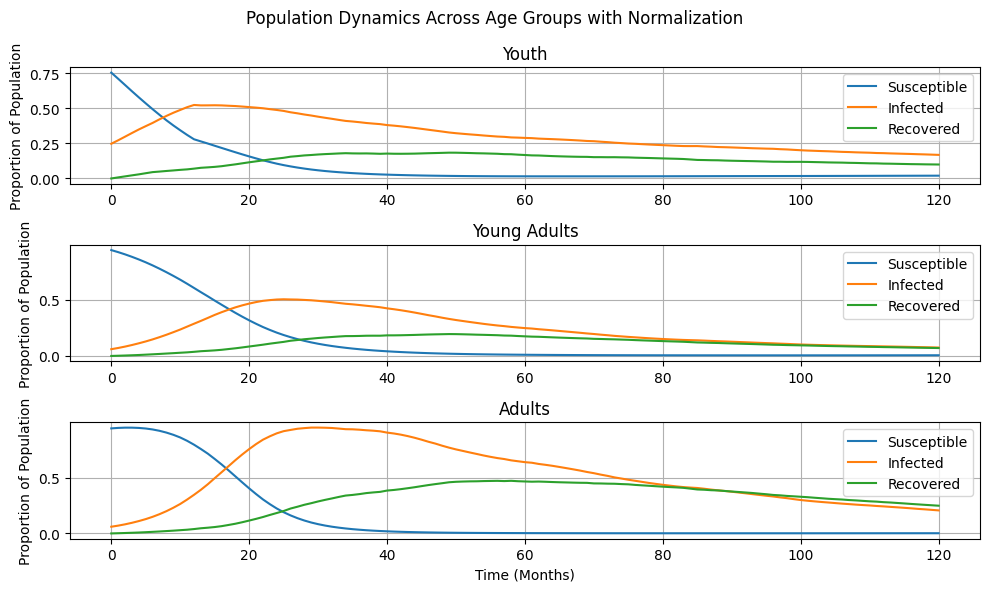

In [80]:
# Plotting results
plt.figure(figsize=(10, 6))
# Subplot for Youth
plt.subplot(3, 1, 1)
plt.plot(t, sol[:, 0], label='Susceptible')
plt.plot(t, sol[:, 1], label='Infected')
plt.plot(t, sol[:, 2], label='Recovered')
plt.title('Youth')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Young Adults
plt.subplot(3, 1, 2)
plt.plot(t, sol[:, 3], label='Susceptible')
plt.plot(t, sol[:, 4], label='Infected')
plt.plot(t, sol[:, 5], label='Recovered')
plt.title('Young Adults')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Adults
plt.subplot(3, 1, 3)
plt.plot(t, sol[:, 6], label='Susceptible')
plt.plot(t, sol[:, 7], label='Infected')
plt.plot(t, sol[:, 8], label='Recovered')
plt.title('Adults')
plt.xlabel('Time (Months)')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

plt.suptitle('Population Dynamics Across Age Groups with Normalization')
plt.tight_layout()
plt.show()